In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Datasets import load
from torch.utils.data import DataLoader
from model import Conv_Net_Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [4]:
model = Conv_Net_Dropout()
model.load_state_dict(torch.load('/home/julius/OOD/models/model1_drop.pth'))
model.to('cuda')
model.fcs = model.fcs[:-1]
model.eval()

Conv_Net_Dropout(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
  )
  (fcs): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [19]:
def energy(logits, T = 1):
    return -T * torch.logsumexp(logits / T, dim = 1)

In [22]:
mnist_dataset = load('MNIST')(train = False)
mnist_loader = DataLoader(mnist_dataset, batch_size = 128, shuffle = False)

cifar_dataset = load('CIFAR10')(train = False)
cifar_loader = DataLoader(cifar_dataset, batch_size = 128, shuffle = False)

Files already downloaded and verified


In [57]:
with torch.no_grad():
    mnist_logits = []
    for x, y in tqdm(mnist_loader):
        x = x.to('cuda')
        logits = model(x)
        mnist_logits.append(logits.cpu())
    mnist_logits = torch.cat(mnist_logits).numpy()

100%|██████████| 79/79 [00:00<00:00, 150.46it/s]


In [58]:
with torch.no_grad():
    cifar_logits = []
    for x, y in tqdm(cifar_loader):
        x = x.to('cuda')
        logits = model(x)
        cifar_logits.append(logits.cpu())
    cifar_logits = torch.cat(cifar_logits).numpy()

100%|██████████| 79/79 [00:00<00:00, 87.40it/s]


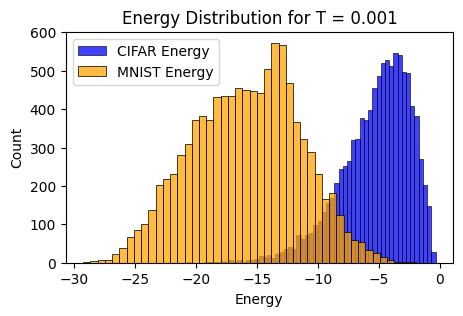

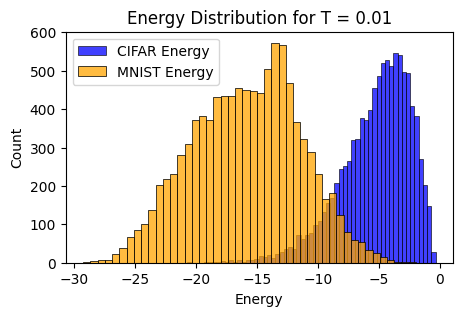

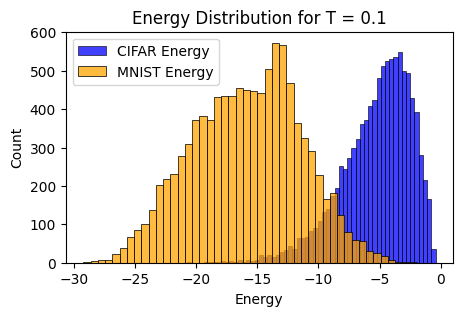

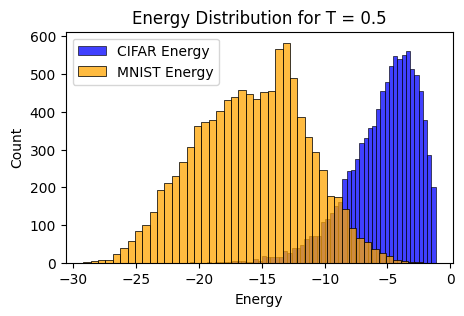

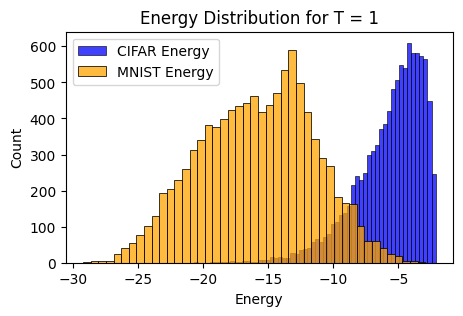

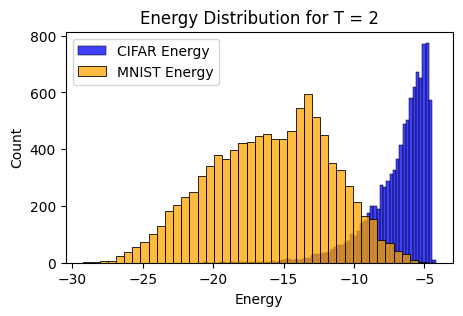

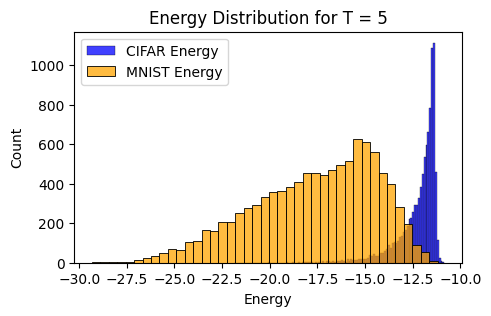

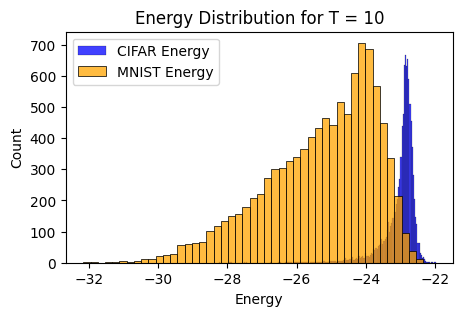

In [40]:
for T in [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]:
    cifar_energy = energy(torch.tensor(cifar_logits), T = T).numpy()
    mnist_energy = energy(torch.tensor(mnist_logits), T = T).numpy()
    plt.figure(figsize=(5, 3))
    sns.histplot(cifar_energy, color='blue', label='CIFAR Energy')
    sns.histplot(mnist_energy, color='orange', label='MNIST Energy')
    plt.xlabel('Energy')
    plt.ylabel('Count')
    plt.title(f'Energy Distribution for T = {T}')
    plt.legend()
    plt.show()


In [70]:
T = 1
cifar_energy1 = energy(torch.tensor(cifar_logits), T = T).numpy()
mnist_energy1 = energy(torch.tensor(mnist_logits), T = T).numpy()

T = 2
cifar_energy2 = energy(torch.tensor(cifar_logits), T = T).numpy()
mnist_energy2 = energy(torch.tensor(mnist_logits), T = T).numpy()

T = 10
cifar_energy10 = energy(torch.tensor(cifar_logits), T = T).numpy()
mnist_energy10 = energy(torch.tensor(mnist_logits), T = T).numpy()

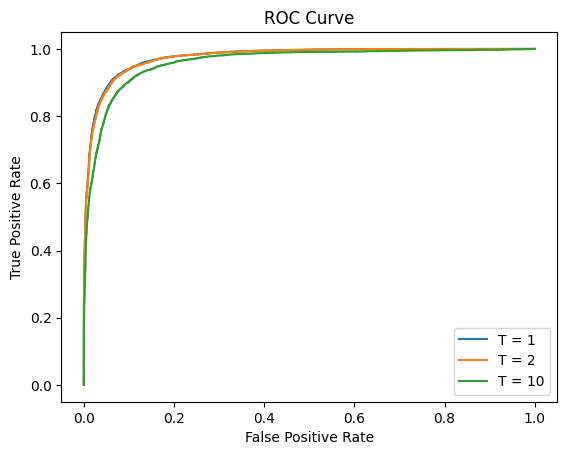

In [71]:
fpr1,tpr1, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_energy1),np.ones_like(mnist_energy1))),np.concatenate(( -cifar_energy1, -mnist_energy1)))
fpr2,tpr2, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_energy2),np.ones_like(mnist_energy2))),np.concatenate(( -cifar_energy2, -mnist_energy2)))
fpr10,tpr10, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_energy10),np.ones_like(mnist_energy10))),np.concatenate(( -cifar_energy10, -mnist_energy10)))

plt.plot(fpr1, tpr1, label = 'T = 1')
plt.plot(fpr2, tpr2, label = 'T = 2')
plt.plot(fpr10, tpr10, label = 'T = 10')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
